In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from scipy.ndimage import measurements
from skimage.morphology import label
from z3 import *
from IPython.display import Markdown, display,HTML,Image

### Puzzle as published 
https://www.janestreet.com/puzzles/it-s-symmetric-2-index/

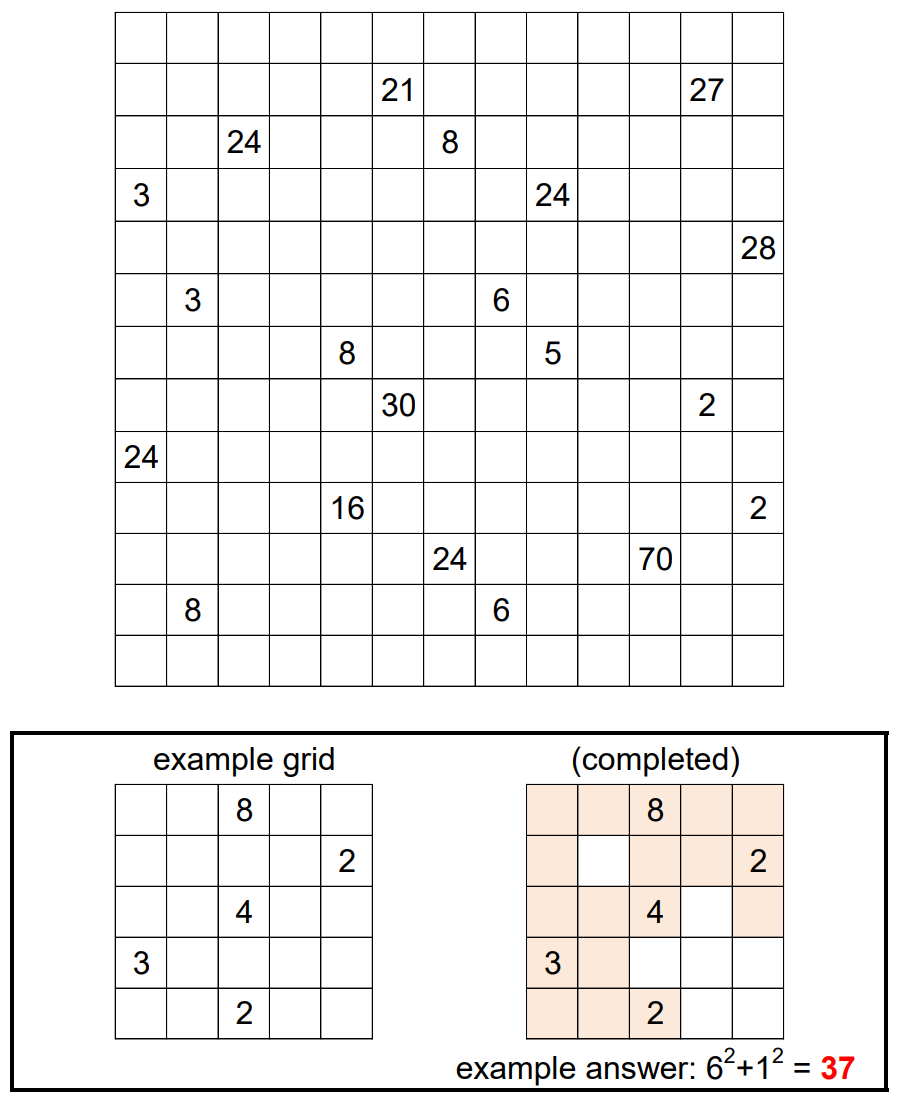

In [2]:
url='https://www.janestreet.com/puzzles/it-s-symmetric-2-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
display(HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1])))
display(Image('https://www.janestreet.com/puzzles/2021-07-01-its-symmetric-2.png',width=200))

In [12]:
# Set up the grids to be solved 
grid1 =  np.array([[0, 0, 8, 0, 0],
                  [0, 0, 0, 0, 2],
                  [0, 0, 4, 0, 0],
                  [3, 0, 0, 0, 0],
                  [0, 0, 2, 0, 0]],dtype=int)

grid = np.array([[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0,21, 0, 0, 0, 0, 0,27, 0],
                 [ 0, 0,24, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
                 [ 3, 0, 0, 0, 0, 0, 0, 0,24, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,28],
                 [ 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 8, 0, 0, 0, 5, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0,30, 0, 0, 0, 0, 0, 2, 0],
                 [24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0,16, 0, 0, 0, 0, 0, 0, 0, 2],
                 [ 0, 0, 0, 0, 0, 0,24, 0, 0, 0,70, 0, 0],
                 [ 0, 8, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],dtype=int)

In [18]:
# function to do the looks ()
def find(data,N):
    data += [0] * max(0, N - len(data))
    if N==13:
        return      If(data[1]==0,1,
                    If(data[2]==0,1,
                    If(data[3]==0,2,
                    If(data[4]==0,3,
                    If(data[5]==0,4,
                    If(data[6]==0,5,
                    If(data[7]==0,6,
                    If(data[8]==0,7,
                    If(data[9]==0,8,
                    If(data[10]==0,9,
                    If(data[11]==0,10,
                    If(data[12]==0,11,12)                
                   )))))))))))
    else:
        return     If(data[1]==0,1,
                   If(data[2]==0,1,
                   If(data[3]==0,2,
                   If(data[4]==0,3,4)
                   )))
         
# neighbour checks to simplify the connected check
def neighbours(i,j,N):
    neigh = [(0,-1),(0,1),(1,0),(-1,0)]
    between = lambda x: x>=0 and x<N
    return [(i+x,j+y) for x,y in neigh if between(i+x)and between(j+y)]

#main code
def solve(grid,fixed=np.ones_like(grid,dtype=int)*-1,sym_type=1):
    start = time.time()
    N = grid.shape[0]

    #set up the solver and variables.
    s = Tactic("qffd").solver()
    X = np.array(IntVector("x",N*N),dtype=object).reshape((N,N))

    # limit the values and place the fixed values
    s += [Or(x==0,x==1) for (i,j),x in np.ndenumerate(X)]
    s += [x == int(fixed[i,j]) for (i,j),x in np.ndenumerate(X) if fixed[i,j] != -1]
    
    # the numbered cells = 1
    s+= [x == 1 for (i,j),x in np.ndenumerate(X)if grid[i,j] != 0]
        
    # force symmetry .. based on the options chosen
    if sym_type == 0:
        pass
    
    elif sym_type == 1:
        test = np.rot90(np.fliplr(X))
        s += [x == test[i,j] for (i,j),x in np.ndenumerate(X)]             
        
    elif sym_type == 2:
        cut = X[:-1,:]
        test = np.rot90(cut,2)
        s += [cut[i,j] == test[i,j] for j in range(N) for i in range(N-1)]
   
    # find the looks
    for i,j in itertools.product(range(N),repeat=2):
        val = grid[i,j]
        if val != 0:
            top = find([X[x,j] for x in range(i,-1,-1)],N)
            bot = find([X[x,j] for x in range(i,N)],N)
            lhs = find([X[i,x] for x in range(j,-1,-1)],N)
            rhs = find([X[i,x] for x in range(j,N)],N)
            s += top*bot*lhs*rhs == int(val)
                        
    # at least one neighbour. Cut down the connectivity a bit.
    s += [Implies(e !=0,Or([X[k][l] !=0 for (k,l) in neighbours(i,j,N)])) for (i,j),e in np.ndenumerate(X) ] 
        
    # coding up the connectivity is hard so just solve and test then exclude solutions that are not connected
    count = 0
    while True: 
        if s.check() == sat:
            count += 1
            m = s.model()
            evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
            x = evalu(X)
            if np.max(label(x != 0,connectivity=1)) == 1 :
                print('{} solutions took {:0.4f} seconds'.format(count,time.time()-start))
                yield x,grid
            s += Or([e!=int(x[i,j]) for (i,j),e in np.ndenumerate(X)])
        else:
            break
            
# Sum of squares of blank areas          
def answer(grid):
    labels, num = measurements.label(grid==0)
    areas = measurements.sum(grid==0, labels, index=range(1, num+1))
    print(areas,sum(areas**2))
    return np.sum([i**2 for i in areas])

1 solutions took 0.2922 seconds


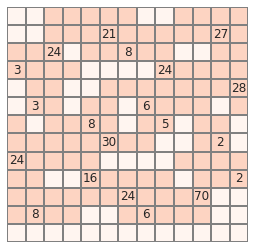

[ 4.  2.  1.  2.  7.  2.  2.  1.  1.  7.  2.  2.  1. 19.] 503.0


**The solution is 503**

Test symmetry is:  True


In [19]:
# after looking at the forced cells the 180 degree rotation symmetry pops out.
# 27 has to have 3 & 7 and there is only one way of doing that 
# which means the 21 has 7 the other way giving row 2 columns 3-13 as forced. Similar for the 70 the 10 is forced 
# then looked to see how that could be done. 
# The bottom row can all be zeros, but the top row can't
#
# Is a unique solution which is encouraging

soln = np.ones_like(grid)*-1
soln[-1,:]=0

for out,fix in solve(grid,fixed=soln,sym_type =2):
    fig,ax = plt.subplots(1,1,figsize=(out.shape[0]**.3*2,out.shape[1]**.3*2)) 
    y = np.array(fix).astype('int').astype('str')
    y[y=="0"] =""
    sns.heatmap(out,annot=y,cbar=False,cmap="Reds",fmt="",linewidths=2,center=3,linecolor="grey",annot_kws={"size":12},vmin=0)
    ax.axis("off")
    plt.show()
    display(Markdown("**The solution is {:,.0f}**".format(answer(out))))

print("Test symmetry is: ",np.all(out[:-1,:] == np.flip(out[:-1,:])))

In [6]:
# Pull in the puzzle solution and grids from the solution page
url='https://www.janestreet.com/puzzles/it-s-symmetric-2-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[10:11]))))

### It's Symmetric 2

The above image shows the shaded region, which exhibits 180-degree
symmetry about its center (which sneakily doesn’t coincide with the
center of the given grid). The sum of the squares of the area of the
connected unshaded regions comes to 503.

<img src="https://www.janestreet.com/puzzles/2021-07-01-its-symmetric-2-solution.png" width="400">

1 solutions took 0.0359 seconds


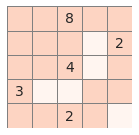

[2. 2. 1.] 9.0


**The solution is 9**

2 solutions took 0.1097 seconds


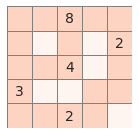

[1. 2. 2. 1.] 10.0


**The solution is 10**

3 solutions took 0.1805 seconds


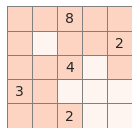

[1. 6.] 37.0


**The solution is 37**

4 solutions took 0.2514 seconds


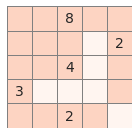

[5. 1.] 26.0


**The solution is 26**

5 solutions took 0.3221 seconds


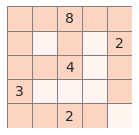

[1. 5. 1.] 27.0


**The solution is 27**

In [7]:
for out,fix in solve(grid1,sym_type=1):
    fig,ax = plt.subplots(1,1,figsize=(out.shape[0]**.5,out.shape[1]**.5)) 
    y = np.array(fix).astype('int').astype('str')
    y[y=="0"] =""
    sns.heatmap(out,annot=y,cbar=False,cmap="Reds",fmt="",linewidths=1,center=3,linecolor="grey",annot_kws={"size":14})
    ax.axis("off")
    plt.show()
    display(Markdown("**The solution is {:,.0f}**".format(answer(out))))    